In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import MaxAbsScaler

from utils import summary_table

In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.2.0


$$y_{t}= \tau + \sum \limits _{m=1} ^{M} \beta_{m} f(x_{t,m};w) + \sum \limits_{c=1} ^{C} \gamma_{c} z_{t,c} +\epsilon_{t} $$

$$f(x,w_{m},L)= \frac{\sum \limits _{l=0} ^{L-1} w_{m}(l;\alpha_{m},\theta_{m})x_{t-l,m}}{\sum \limits _{l=0} ^{L-1} w_{m}(l)} $$


$$w_{m}(l;\alpha_{m},\theta_{m})=\alpha_{m} ^{(l-\theta_m)^2} $$

In [3]:
raw = pd.read_csv('MMM_test_data.csv')
df=raw.copy()

In [4]:
df['start_of_week'] 

0      30-08-20
1      06-09-20
2      13-09-20
3      20-09-20
4      27-09-20
         ...   
99     24-07-22
100    31-07-22
101    07-08-22
102    14-08-22
103    21-08-22
Name: start_of_week, Length: 104, dtype: object

In [5]:
df['start_of_week'] = pd.to_datetime(df['start_of_week'],format="%d-%m-%y",dayfirst=True)
df.set_index('start_of_week', inplace=True)

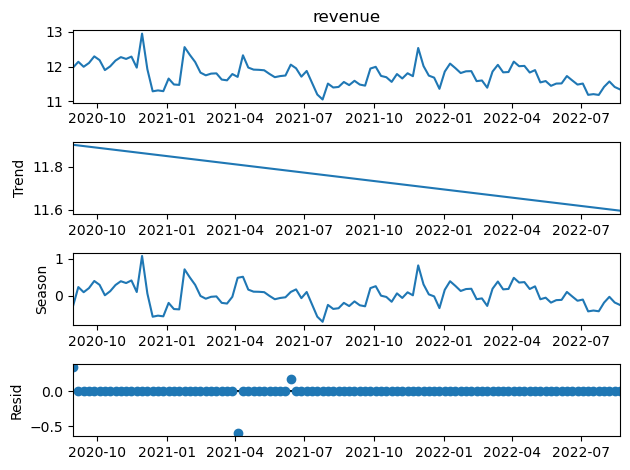

In [131]:
from statsmodels.tsa.seasonal import STL

stl = STL(np.log(df['revenue']), seasonal=7,robust=True)
res = stl.fit()
fig = res.plot()

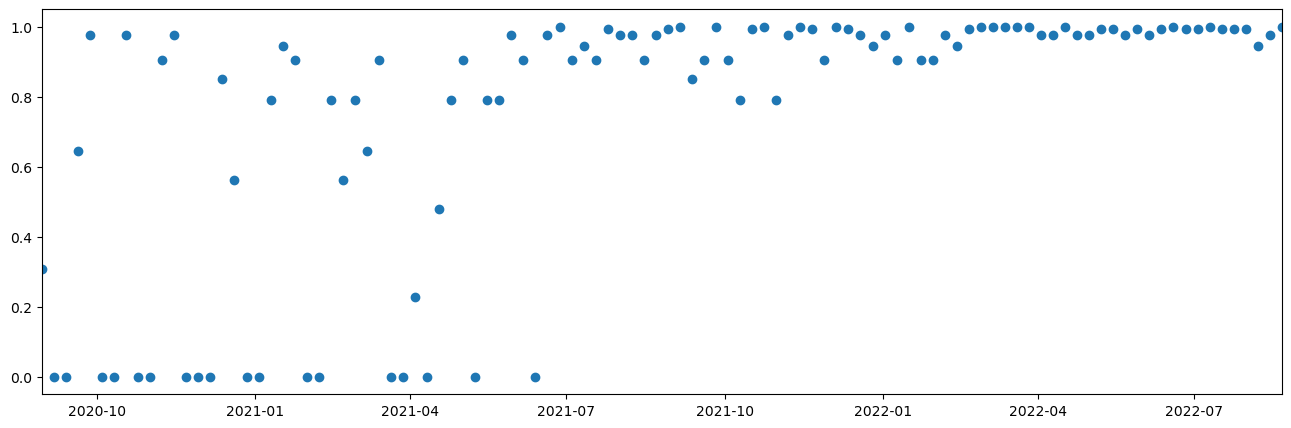

In [108]:


fig = plt.figure(figsize=(16, 5))
lines = plt.plot(res.weights, marker="o", linestyle="none")
ax = plt.gca()
xlim = ax.set_xlim(df.index[0], df.index[-1])



/tmp/ipykernel_160411/2983186589.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

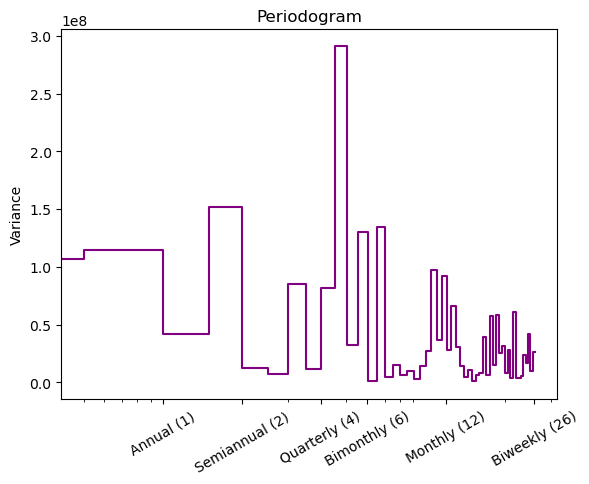

In [129]:
plot_periodogram(df.revenue)

/tmp/ipykernel_160411/3373574529.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X["week"] = X.index.week  # the seasonal period (period)
/tmp/ipykernel_160411/1565446183.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


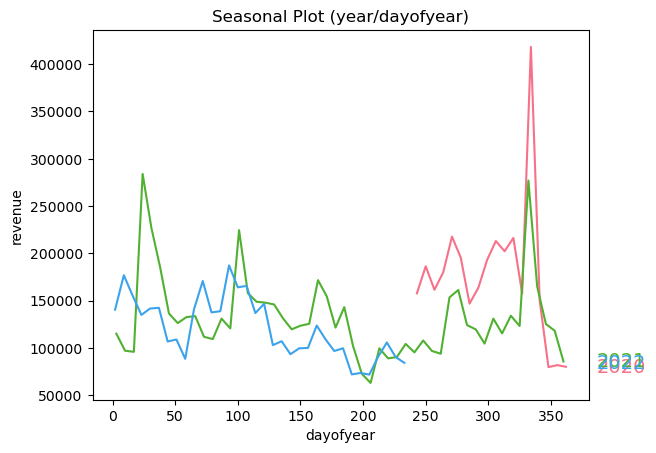

In [122]:
X = df.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)
X["month"] =  X.index.month

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
seasonal_plot(X, y="revenue", period="year", freq="dayofyear")
plt.show()


In [95]:
n_order = 6
df["week"] = X.index.week 
periods = df["week"] / 52.1429
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)





/tmp/ipykernel_160411/3560899953.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["week"] = X.index.week


In [97]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [51]:
from statsmodels.tsa.stattools import pacf_ols

pacf_ols(df.revenue)

array([ 1.        ,  0.45098196,  0.09793483,  0.02465994,  0.01492149,
        0.02580962, -0.06195144,  0.00735106,  0.38435683,  0.15411098,
       -0.05933931, -0.06248097,  0.0540507 , -0.06277158,  0.08470762,
       -0.01169607, -0.14782994, -0.06716089,  0.01296662,  0.17619246,
       -0.03624028])

In [ ]:
rwm = raw.melt('start_of_week',var_name='cols', value_name='vals')
rwm['type']= 'daily'
weekly = rwm.groupby([pd.to_datetime(rwm.start_of_week).dt.week,'cols']).mean().reset_index()
weekly['type']='weekly'
monthly = rwm.groupby([pd.to_datetime(rwm.start_of_week).dt.month,'cols']).mean().reset_index()
monthly['type']='monthly'
df_table= rwm.append(weekly, ignore_index=True).append(monthly,ignore_index=True)


In [ ]:
sns.relplot(data=df_table, x="start_of_week", y="vals", col="type",row='cols',kind="line", facet_kws=dict(sharex=False,sharey=False))

In [ ]:
df['day'] = pd.to_datetime(df.start_of_week).dt.dayofyear
df['week'] = pd.to_datetime(df.start_of_week).dt.week
df['month'] = pd.to_datetime(df.start_of_week).dt.month
df['year'] = pd.to_datetime(df.start_of_week).dt.year

In [ ]:
df

In [128]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1W")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [ ]:
df.corr()

In [ ]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(df.revenue, lags = 50, ax = plt.gca(),fft=True)
plt.subplot(422); plot_pacf(df.revenue, lags = 50, ax = plt.gca())

plt.show()



In [ ]:
_ = plot_lags(df.revenue, lags=24, nrows=4)

In [ ]:
def lagplot(x, y=None, lag=1, standardize=True, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [ ]:
df['week'] = pd.to_datetime(df.start_of_week).dt.day
df['month'] = pd.to_datetime(df.start_of_week).dt.month
df['year'] = pd.to_datetime(df.start_of_week).dt.year


In [ ]:
spend_channels= ['spend_channel_1','spend_channel_2','spend_channel_3','spend_channel_4','spend_channel_5','spend_channel_6','spend_channel_7']
# df['total_spent'] = df[spend_channels].sum(axis=1)

In [ ]:
raw.melt('start_of_week',var_name='cols', value_name='vals')

In [ ]:
rwm = raw.melt('start_of_week',var_name='cols', value_name='vals')


In [ ]:
rwm[rwm['cols']=='revenue']

In [ ]:
rwm.mask(rwm['cols']=='revenue').dropna()

In [ ]:
sns.lineplot(data=rwm.mask(rwm['cols']=='revenue').dropna(), x=pd.to_datetime(rwm.start_of_week).dt.week,y='vals',hue='cols')

In [ ]:
rwm[rwm['cols']=='revenue']

In [ ]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [ ]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

In [ ]:
pm.model_to_graphviz(basic_model)

In [ ]:
idata


In [ ]:
az.plot_trace(idata, combined=True);

In [ ]:
az.summary(idata, round_to=2)

In [ ]:
az.plot_energy(idata);

In [ ]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

In [ ]:
spend_channels= ['spend_channel_1','spend_channel_2','spend_channel_3','spend_channel_4','spend_channel_5','spend_channel_6','spend_channel_7']
spends = df[spend_channels].copy()